For details, see [here](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [here](http://danielhnyk.cz/predicting-sequences-vectors-keras-using-rnn-lstm/) and [here](https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent)

# Imports

In [14]:
##########
# basics #
##########

import warnings
warnings.filterwarnings('ignore')
import collections
import datetime
import glob
import hashlib
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time

###########
# science #
###########

import scipy as sp
import numpy as np
import pandas as pd
rseed = random.seed(42)
np.random.seed(rseed)

######
# ml #
######

import theano as thno
import keras as krs
import tensorflow as tf

###################
# sklearn tooling #
###################

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=False, theme='pearl')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted', n_colors=15, desat=None)
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

############
# sys info #
############

%reload_ext watermark
%watermark -a "Author: Ken Cavagnolo" -n -z -u -v -h -m -g -r

print("\nPackage versions:")
%watermark -w -p numpy,scipy,pandas,sklearn,theano,keras,tensorflow,matplotlib,seaborn,plotly

Author: Ken Cavagnolo 
last updated: Sun May 07 2017 EDT

CPython 3.5.2
IPython 6.0.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : DrGonzo.local
Git hash   : 6d2f20d04f7ca100f2801f9ad350da6a9d436e12
Git repo   : git@github-kc:kcavagnolo/ml_fun.git

Package versions:
numpy 1.12.1
scipy 0.19.0
pandas 0.19.2
sklearn 0.18.1
theano 0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
keras 2.0.4
tensorflow 1.1.0
matplotlib 2.0.1
seaborn 0.7.1
plotly 1.12.9
watermark 1.4.0


# Data

In [36]:
def sine_generator(intervals, f0, fs):
    t = np.arange(intervals)
    sinusoid = np.sin(2*np.pi*t*(f0/fs))
    sinusoid = sinusoid/max(sinusoid)
    return sinusoid

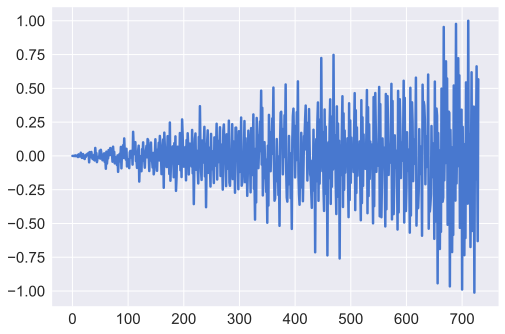

In [40]:
sinusoid = sine_generator(365*2, 3, 2)
plt.plot(sinusoid);

In [51]:
df = pd.read_csv('../../datasets/international-airline-passengers.csv',
                 usecols=[1],
                 engine='python',
                 skipfooter=3)

In [52]:
df.describe()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [53]:
df.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


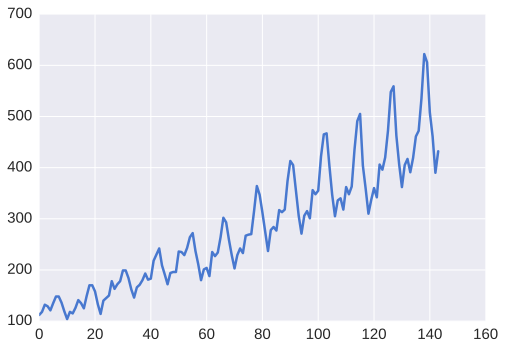

In [54]:
# below fails bc of bullshit zscaler ssl cert inspection
#df.iplot(legend=None)

plt.plot(df)

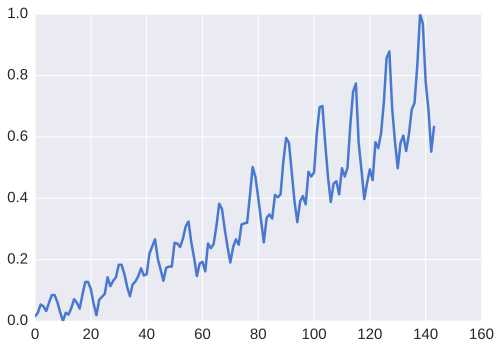

In [55]:
# scale data
scaler = preprocessing.MinMaxScaler()

# transform
df_scl = df.copy()
for c in df.columns:
    df_scl[[c]] = scaler.fit_transform(df[[c]])
    
# viz
plt.plot(df_scl)

# Functions

In [116]:
def pick_cv(data, folds=5):
    cv_min = round(0.5*len(data))
    cv_max = len(data)
    return list(set([random.randrange(cv_min, cv_max) for i in range(0, folds)]))

In [119]:
def lags(d, window=3):
    x, y = [], []
    for i in range(len(d)-window):
        x.append(d.iloc[i:i+window].as_matrix())
        y.append(d.iloc[i+window].as_matrix())
    return np.array(x), np.array(y)

# Model

In [126]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [133]:
window = 12
folds = 1

# cv folding
for i in pick_cv(df_scl, folds):
    
    # get train/test split
    train, test = df_scl.iloc[0:i], df_scl.iloc[i:]
    X_train, y_train = lags(train, window)
    X_test, y_test = lags(test, window)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    # build model and train
    model = Sequential()
    model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='linear'))
    model.compile(loss="mse", optimizer="adam")
    bsize = random.randint(window, 3*window)
    model.fit(X_train, y_train, nb_epoch=100, batch_size=bsize, verbose=1)

Epoch 1/100
112/112 [==============================] - 0s - loss: 0.0727     
Epoch 2/100
112/112 [==============================] - 0s - loss: 0.0424     
Epoch 3/100
112/112 [==============================] - 0s - loss: 0.0274     
Epoch 4/100
112/112 [==============================] - 0s - loss: 0.0174     
Epoch 5/100
112/112 [==============================] - 0s - loss: 0.0132     
Epoch 6/100
112/112 [==============================] - 0s - loss: 0.0097     
Epoch 7/100
112/112 [==============================] - 0s - loss: 0.0070     
Epoch 8/100
112/112 [==============================] - 0s - loss: 0.0091     
Epoch 9/100
112/112 [==============================] - 0s - loss: 0.0079     
Epoch 10/100
112/112 [==============================] - 0s - loss: 0.0082     
Epoch 11/100
112/112 [==============================] - 0s - loss: 0.0091     
Epoch 12/100
112/112 [==============================] - 0s - loss: 0.0090     
Epoch 13/100
112/112 [==============================] - 0s - 

# Validation

In [134]:
# make predictions
predictions = model.predict(X_test)

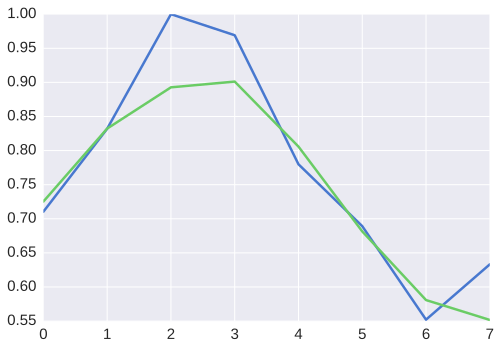

In [135]:
fig = plt.figure()
plt.plot(y_test)
plt.plot(predictions)
plt.show()

# Scratch

In [80]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
dataframe = pd.read_csv('../../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [82]:
trainX.shape

(94, 1, 1)

In [87]:
model = Sequential()
model.add(LSTM(4, input_dim=3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Exception: Error when checking model input: expected lstm_input_6 to have shape (None, None, 3) but got array with shape (94, 1, 1)